In [ ]:
import numpy as np
import pandas as pd
import tensorflow_hub as hub
import librosa
from IPython.display import Audio
import matplotlib.pyplot as plt
import csv
import seaborn as sns
from prettytable import PrettyTable
from google.colab import drive
drive.mount('/content/drive')
import tensorflow as tf
import soundfile as sf
import librosa.display
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, Dropout, LSTM, MaxPooling2D, Flatten, concatenate, Reshape, BatchNormalization
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow_hub as hub
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import Callback,EarlyStopping
import seaborn as sns
from librosa.feature import melspectrogram

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bird_df = pd.read_csv('/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/notebooks/RG/train_val.csv')
bird_df = bird_df[bird_df['duration_secs'] >= 8]

In [ ]:
bird_train_df = bird_df[bird_df['data'] == 'train']
bird_train_df.shape

(1206, 12)

In [ ]:
#lets create a separate validation set
bird_val_df =  bird_df[bird_df['data'] == 'val']
bird_val_df.shape

(402, 12)

In [ ]:
#let's filter the train and the validation data sets to contain only top 5 species for testing
def filter_top_species(bird_train_df, species_list):
    filtered_train_df = bird_train_df[bird_train_df['primary_label'].isin(species_list)]
    filtered_val_df = bird_val_df[bird_val_df['primary_label'].isin(species_list)]
    return filtered_train_df, filtered_val_df

In [ ]:
#lets call the train and the validation filtered sets
species_list = ['comsan', 'woosan', 'eaywag1']
filtered_train_df, filtered_val_df = filter_top_species(bird_train_df, species_list)
print(filtered_train_df.shape)
print(filtered_val_df.shape)

(360, 12)
(119, 12)


In [ ]:
audio_path = '/content/drive/MyDrive/UCB-MIDS/SEM-2/MACHINE-LEARNING-207/207-Project/data/train/librosa_loaded/'

In [ ]:
#Function to load the loudest 5-second audio
def load_audio(file_name):
    audio = np.load(audio_path + file_name)
    return audio

In [ ]:
#chunk the audio into 5 segments with 2.0 seconds overlap
def frame_audio(
      audio_array: np.ndarray,
      window_size_s: float = 10.0,
      hop_size_s: float = 2.0,
      sample_rate = 16000,
) -> np.ndarray:

    """Helper function for framing audio for inference."""
    """ using tf.signal """
    if window_size_s is None or window_size_s < 0:
        return audio_array[np.newaxis, :]
    frame_length = int(window_size_s * sample_rate)
    hop_length = int(hop_size_s * sample_rate)
    framed_audio = tf.signal.frame(audio_array, frame_length, hop_length, pad_end=True)
    return framed_audio

In [ ]:
#lets generate gaussian noise in the frames
def generate_gaussian_noise(length, mean=0, std=0.01):
    gaussian_noise = np.random.normal(mean, std, length)
    return gaussian_noise

#lets extract mel spec from frames
def extract_melspec_from_frames(framed_audio, class_label, sample_rate=16000):
    scaler = MinMaxScaler(feature_range=(0, 1))
    melspec_frames = []
    target_label = []

    for frame in framed_audio:
        frame = np.array(frame)

        # Extract mel spec from the main audio frame without augmentation
        log_mel_spec = melspectrogram(y=frame, sr=sample_rate)
        mel_spec_processed = librosa.power_to_db(log_mel_spec, ref=np.max)

        # Replicate frame
        replicated_frame_1 = frame.copy()
        replicated_frame_3 = frame.copy()

        # Flip the third frame
        flipped_frame = np.flip(replicated_frame_3)

        # Add Gaussian noise to the first frame alone
        gaussian_noise_1 = generate_gaussian_noise(len(replicated_frame_1))
        replicated_frame_1 += gaussian_noise_1

        # Extract mel spec features from the augmented frames
        log_mel_spec_2 = melspectrogram(y=replicated_frame_1, sr=sample_rate)
        mel_spec_2_processed = librosa.power_to_db(log_mel_spec_2, ref=np.max)

        log_mel_spec_3 = melspectrogram(y=flipped_frame, sr=sample_rate)
        mel_spec_3_processed = librosa.power_to_db(log_mel_spec_3, ref=np.max)

        # Append the mel spec processed to melspec list
        melspec_frames.append(mel_spec_processed)
        melspec_frames.append(mel_spec_2_processed)
        melspec_frames.append(mel_spec_3_processed)

        target_label.append(class_label)
        target_label.append(class_label)
        target_label.append(class_label)

    return melspec_frames, target_label

In [ ]:
def extract_final_features_from_dataframe(df):
    melspecs = []
    target_labels = []
    for index, row in df.iterrows():
        file_name = str(row['filename_npy'])
        class_label = row["primary_label"]
        audio = load_audio(file_name)  # Load the audio using the load_audio function
        framed_audio = frame_audio(audio)  # Frame the audio into 5-second segments
        melspec_frames, target_label = extract_melspec_from_frames(framed_audio, class_label, sample_rate=16000)  # Extract MFCC features for each frame
        melspecs.extend(melspec_frames)
        target_labels.extend(target_label)
    return melspecs, target_labels

In [ ]:
#let us normalize the mel spectograms
def normalize_melspectrograms(data):
    scaler = MinMaxScaler()
    reshaped_data = data.reshape(data.shape[0], -1)
    normalized_data = scaler.fit_transform(reshaped_data)
    return normalized_data

In [ ]:
#let us create a function to shuffle the data
def shuffle_data(x, y, random_state=42):
    num_samples = x.shape[0]
    random_indices = np.random.RandomState(random_state).permutation(num_samples)
    x_shuffled = x[random_indices]
    y_shuffled = y[random_indices]
    return x_shuffled, y_shuffled

In [ ]:
#let us get the encoded y_train and y_val
def encode_labels(y_train, y_val):
    # Perform one-hot encoding on y_train
    le = LabelEncoder()
    encoded_y_train = to_categorical(le.fit_transform(y_train))

    # Perform one-hot encoding on y_val
    le = LabelEncoder()
    encoded_y_val = to_categorical(le.fit_transform(y_val))

    return encoded_y_train, encoded_y_val

In [ ]:
#extract the embeddings from the model
mel_spec_embeddings, labels = extract_final_features_from_dataframe(filtered_train_df)

In [ ]:
len(mel_spec_embeddings)

19932

In [ ]:
mel_spec_embeddings = np.array(mel_spec_embeddings)

In [ ]:
#let us check the normalized mel spec values in the train data
normalized_train = normalize_melspectrograms(mel_spec_embeddings)
print(np.amax(mel_spec_embeddings))
print(np.amax(normalized_train))

7.6293945e-06
1.0000001


In [ ]:
#verify x_train shape
x_train = normalized_train
print(x_train.shape)

(8760, 20096)


In [ ]:
#verify the shapes
y_train = np.array(labels)
print(y_train.shape)

(8760,)


In [ ]:
#lets extract the mel spectogram from the validation dataset
val_embeddings, val_labels = extract_final_features_from_dataframe(filtered_val_df)

In [ ]:
len(val_embeddings)

6252

In [ ]:
val_mel_spec_embeddings = np.array(val_embeddings)

In [ ]:
#let us check the normalized mel spec values in the train data
normalized_val = normalize_melspectrograms(val_mel_spec_embeddings)
print(np.amax(val_mel_spec_embeddings))
print(np.amax(normalized_val))

3.8146973e-06
1.0000001


In [ ]:
x_val = normalized_val
print(x_val.shape)

(2745, 20096)


In [ ]:
#verify the shapes
y_val = np.array(val_labels)
print(y_val.shape)

(2745,)


In [ ]:
# shuffle both train and validation sets
x_shuffled_train, y_shuffled_train = shuffle_data(x_train, y_train)
x_shuffled_val, y_shuffled_val = shuffle_data(x_val, y_val)

In [ ]:
#lets call the function to encode y
y_train_encoded, y_val_encoded = encode_labels(y_shuffled_train, y_shuffled_val)

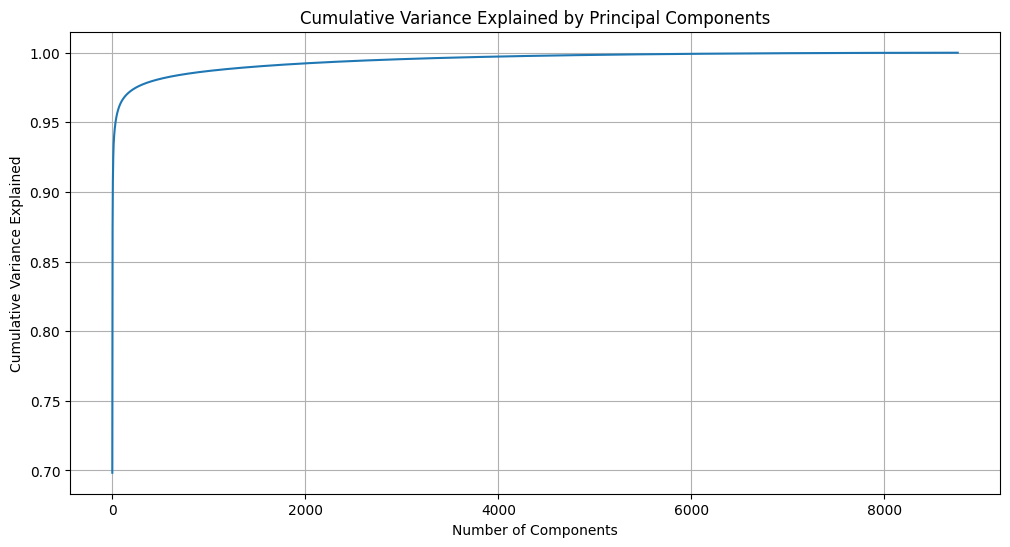

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Perform PCA
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
pca = PCA()
pca.fit(x_train_scaled)

# Plot cumulative variance
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained by Principal Components')
plt.grid(True)
plt.show()


In [ ]:
#lets perform PCA and select only the essential features
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def apply_pca(x_train, x_val, desired_variance=4000):
    # Fit PCA on x_train
    pca = PCA(n_components=4000)
    x_train_pca = pca.fit_transform(x_train)

    # Apply the same PCA transformation on x_val
    x_val_pca = pca.transform(x_val)

    return x_train_pca, x_val_pca

#lets call the pca function
x_train_pca, x_val_pca = apply_pca(x_shuffled_train, x_shuffled_val)

Decision Tree Classifier - Decision trees and random forests in scikit-learn can handle input data (X) with multiple dimensions, including three-dimensional shapes. However, they are primarily designed for tabular data where each sample is represented by a fixed number of features (dimensions). The shape of the input data should be (n_samples, n_features).

If you have three-dimensional data, you need to reshape it into a two-dimensional format before using it with decision trees or random forests. This can be achieved by flattening or reshaping the data appropriately.

In [ ]:
from sklearn import tree
from sklearn import metrics

# Call and fit the decision tree classifier
clf = tree.DecisionTreeClassifier()
clf.fit(x_train_pca, y_shuffled_train)

# Predict the labels for the validation data
y_pred = clf.predict(x_val_pca)

# Calculate and print the accuracy
accuracy = metrics.accuracy_score(y_shuffled_val, y_pred)
print("Accuracy:", accuracy)

f1_score = metrics.f1_score(y_shuffled_val, y_pred, average='weighted')
print("F1 Score:", f1_score)

precision = metrics.precision_score(y_shuffled_val, y_pred, average='weighted')
print("Precision:", precision)

Accuracy: 0.5009107468123861
F1 Score: 0.5047905122852966
Precision: 0.5200872380874089


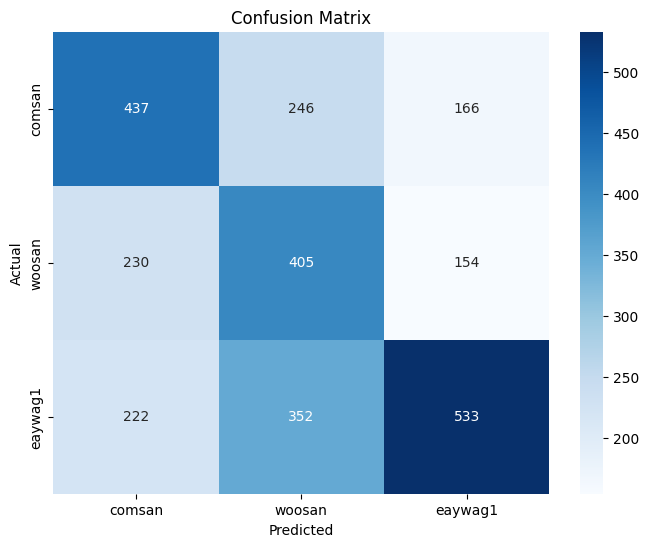

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['comsan', 'woosan', 'eaywag1']

# Calculate and print the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_shuffled_val, y_pred)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Random Forest classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Call and fit the Random Forest classifier
rf_clf = RandomForestClassifier()
rf_clf.fit(x_train_pca, y_shuffled_train)

# Predict the labels for the validation data
y_pred_rf = rf_clf.predict(x_val_pca)

# Calculate and print the accuracy
accuracy_rf = metrics.accuracy_score(y_shuffled_val, y_pred_rf)
print("Random Forest Accuracy:", accuracy_rf)

f1_score_rf = metrics.f1_score(y_shuffled_val, y_pred_rf, average='weighted')
print("Random Forest F1 Score:", f1_score_rf)

precision_rf = metrics.precision_score(y_shuffled_val, y_pred_rf, average='weighted')
print("Random Forest Precision:", precision_rf)

Random Forest Accuracy: 0.49872495446265935
Random Forest F1 Score: 0.48662822613299933
Random Forest Precision: 0.5916408406634655


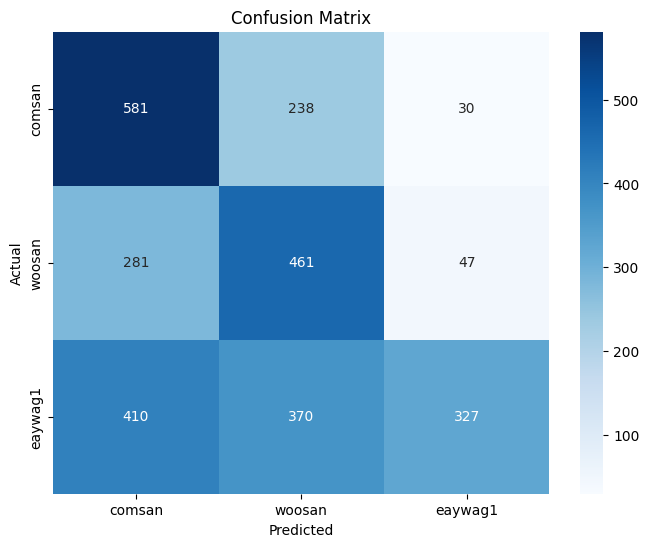

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['comsan', 'woosan', 'eaywag1']

# Calculate and print the confusion matrix
confusion_matrix = metrics.confusion_matrix(y_shuffled_val, y_pred_rf)

# Plot confusion matrix with labels
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Convolution Neural Network

In [ ]:
def preprocess_melspectrograms(melspectrograms):
    #Stack the Mel-spectrograms (3D)
    stacked_mel_spectrograms = np.dstack(melspectrograms)

    # Rotate the array from (x, y, z) axis to (z, x, y) axis
    rotated_mel_spectrograms = np.rot90(stacked_mel_spectrograms, axes=(0, 2))

    # Expand dimensions for Keras (4D)
    x_value = np.expand_dims(rotated_mel_spectrograms, axis=-1)

    return x_value

In [ ]:
x_train = preprocess_melspectrograms(mel_spec_embeddings)
x_val = preprocess_melspectrograms(val_mel_spec_embeddings)

In [ ]:
print(x_train.shape)
print(x_val.shape)

(8760, 157, 128, 1)
(2745, 157, 128, 1)


In [ ]:
# shuffle both train and validation sets
x_shuffled_contrain, y_shuffled_contrain = shuffle_data(x_train, y_train)
x_shuffled_conval, y_shuffled_conval = shuffle_data(x_val, y_val)

In [ ]:
#lets call the function to encode y
y_train_conencoded, y_val_conencoded = encode_labels(y_shuffled_contrain, y_shuffled_conval)

In [ ]:
print(y_train_conencoded.shape)
print(y_val_conencoded.shape)

(8760, 3)
(2745, 3)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras import optimizers

import tensorflow as tf

def create_model(input_shape, num_classes):
    model = tf.keras.Sequential()

    model.add(tf.keras.layers.Conv2D(16, (3, 3), input_shape=input_shape))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))  # Add dropout layer with dropout rate of 0.2


    model.add(tf.keras.layers.Conv2D(64, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))  # Add dropout layer with dropout rate of 0.2


    model.add(tf.keras.layers.Conv2D(64, (3, 3)))
    model.add(tf.keras.layers.Activation('relu'))
    model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))  # Add dropout layer with dropout rate of 0.2


    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(units=num_classes, name='fc_2', activation=None, kernel_regularizer=tf.keras.regularizers.l2(0.001)))

    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

    return model


# Create the model for training
input_shape = x_train.shape[1:]
num_classes = 3
model = create_model(input_shape, num_classes)

In [ ]:
#earlystop = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='auto')
# Train the model using the provided data
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
history = model.fit(x_shuffled_contrain, y_train_conencoded, batch_size=16, callbacks=[reduce_lr], epochs=30, validation_data=(x_shuffled_conval, y_val_conencoded))